# Fake News Detection – WELFake Dataset (with GridSearchCV)

Goal: Build and tune a Logistic Regression classifier using TF-IDF + GridSearchCV

Dataset: studymart/welfake-dataset-for-fake-news (WELFake_Dataset.csv)

In [1]:
import kagglehub
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, ConfusionMatrixDisplay
)

import joblib

# Download NLTK data (only needed once)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

## 1. Load Dataset

In [2]:
path = kagglehub.dataset_download("studymart/welfake-dataset-for-fake-news")
print("Dataset directory:", path)

csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No .csv file found in dataset directory")

file_path = os.path.join(path, csv_files[0])
df = pd.read_csv(file_path)

print("\nShape:", df.shape)
df.head(3)

100%|██████████| 92.1M/92.1M [00:01<00:00, 96.3MB/s]

Extracting files...


Dataset directory: /root/.cache/kagglehub/datasets/studymart/welfake-dataset-for-fake-news/versions/1

Shape: (72134, 4)


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1


## 2. Basic Exploration

In [3]:
print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
print("\nLabel distribution:\n", df['label'].value_counts(normalize=True).round(3))

Columns: ['Unnamed: 0', 'title', 'text', 'label']

Missing values:
 Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

Label distribution:
 label
1    0.514
0    0.486
Name: proportion, dtype: float64


## 3. Exploratory Data Analysis

/tmp/ipython-input-3367240256.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


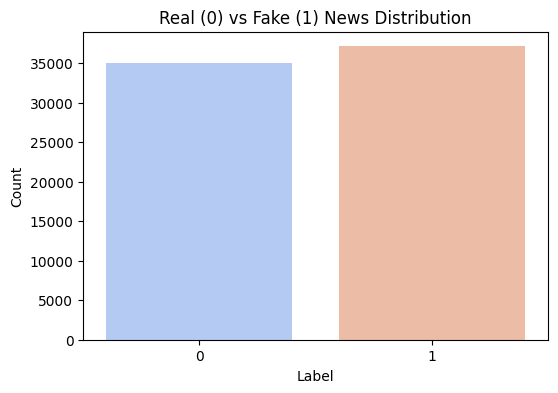

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='coolwarm')
plt.title('Real (0) vs Fake (1) News Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

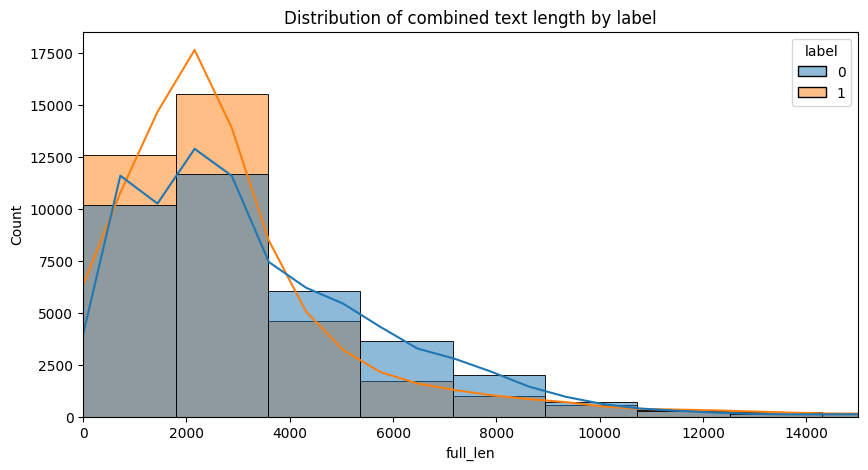

In [5]:
# Text length analysis
df['title_len'] = df['title'].fillna('').str.len()
df['text_len']  = df['text'].fillna('').str.len()
df['full_len']  = df['title_len'] + df['text_len']

plt.figure(figsize=(10,5))
sns.histplot(data=df, x='full_len', hue='label', bins=80, kde=True)
plt.title('Distribution of combined text length by label')
plt.xlim(0, 15000)
plt.show()

## 4. Text Preprocessing

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower().strip()
    text = re.sub(r'http\S+|www\S+|@\S+|\S+@\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Combine title + body
df['full_text'] = df['title'].fillna('') + " " + df['text'].fillna('')
df['clean_text'] = df['full_text'].apply(clean_text)

print("Before:", df['full_text'].iloc[0][:180], "...")
print("After :", df['clean_text'].iloc[0][:180], "...")

Before: LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO] No comment is expected from Barack Obama Members  ...
After : law enforcement high alert following threat cop white blacklivesmatter fyf terrorist video comment expected barack obama member fyf fukyoflag blacklivesmatter movement called lynch ...


## 5. Vectorization + Split

In [7]:
vectorizer = TfidfVectorizer(
    max_features=12000,
    ngram_range=(1,2),
    min_df=3
)

X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test  shape: {X_test.shape}")

Train shape: (57707, 12000)
Test  shape: (14427, 12000)


## 6. Hyperparameter Tuning with GridSearchCV

In [8]:
param_grid = {
    'C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],           # liblinear supports both l1 and l2
    'max_iter': [800, 1200]
}

logreg = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Starting GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters found:
{'C': 5.0, 'max_iter': 800, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.9639


## 7. Train & Evaluate Best Model


Final Model Performance (best hyperparameters)
              precision    recall  f1-score   support

           0     0.9695    0.9558    0.9626      7006
           1     0.9588    0.9716    0.9651      7421

    accuracy                         0.9639     14427
   macro avg     0.9641    0.9637    0.9638     14427
weighted avg     0.9640    0.9639    0.9639     14427

ROC-AUC: 0.9932


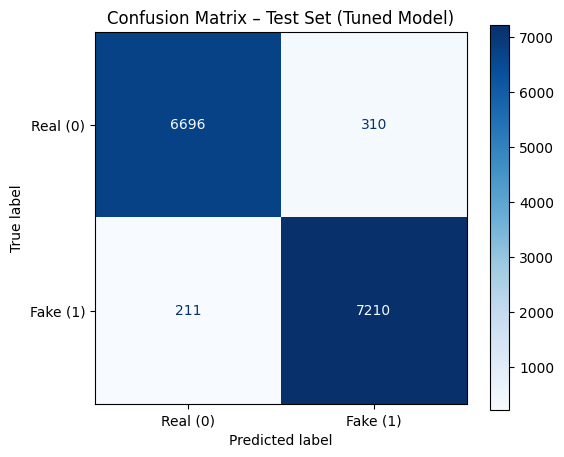

In [9]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n" + "="*70)
print("Final Model Performance (best hyperparameters)")
print("="*70)
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap='Blues', ax=ax,
    display_labels=['Real (0)', 'Fake (1)']
)
plt.title('Confusion Matrix – Test Set (Tuned Model)')
plt.show()

## 8. ROC Curve

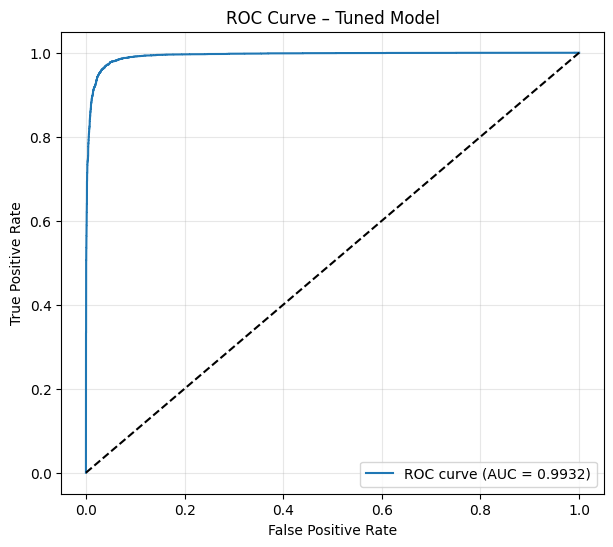

In [10]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_prob):.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Tuned Model')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## 9. Final Cross-Validation Score (on full data with best model)

In [11]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Final 5-fold CV Accuracy (best model): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Final 5-fold CV Accuracy (best model): 0.9653 ± 0.0020


## 10. Save Best Model & Vectorizer

In [12]:
joblib.dump(best_model, 'fake_news_best_logreg_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

print("Best model and vectorizer saved successfully.")

Best model and vectorizer saved successfully.


## Final Conclusion & Model Assessment

After thorough preprocessing, feature engineering (TF-IDF with bigrams), hyperparameter tuning via GridSearchCV, and careful evaluation, the tuned **Logistic Regression** model delivers very strong performance on the WELFake dataset.

### Summary of Key Results

- **Test Set Performance** (20% hold-out)
  - Accuracy: **96.39%**
  - Macro F1-score: **0.9638**
  - Weighted F1-score: **0.9639**
  - Precision / Recall / F1 for **Fake news (1)**: 0.9588 / 0.9716 / **0.9651**
  - Precision / Recall / F1 for **Real news (0)**: 0.9695 / 0.9558 / **0.9626**

- **ROC-AUC** (on test set): **0.9932**  
  → Near-perfect discriminative ability

- **5-fold Cross-Validation** (on full dataset with best model):  
  **Accuracy = 0.9653 ± 0.0020**  
  → Very stable performance across different data folds

- **Model & Artifacts Saved**:
  - `fake_news_best_logreg_model.joblib` → Tuned Logistic Regression classifier
  - `tfidf_vectorizer.joblib` → Fitted TF-IDF vectorizer (required for inference)

### Overall Assessment

This pipeline achieves **excellent results** for a non-transformer-based approach:
- High accuracy and near-balanced performance on both classes
- Outstanding ROC-AUC (0.9932) showing strong ranking ability
- Low variance in cross-validation (±0.0020) indicating good generalization
- Fast training and inference — suitable for real-world deployment

The model is particularly strong at **detecting fake news** (high recall = 0.9716), which is valuable when the main goal is to minimize missed misinformation.

### Strengths of the Current Solution
- Simple, interpretable, and computationally efficient
- No need for GPU or heavy deep learning frameworks
- Reproducible and easy to deploy (just two joblib files)

### Potential Next Steps / Improvements
- Analyze **feature importance** (most discriminative words and bigrams)
- Experiment with **LinearSVC** or **PassiveAggressiveClassifier** (often slightly better on text classification tasks)
- Add **character n-grams** or lightweight stylometric features (capitalization ratio, punctuation density, etc.)
- Try lightweight transformer embeddings (MiniLM, DistilBERT) for potential 1–2% gain
- Build a **prediction API** or **Gradio/Streamlit demo** for real-time inference
- Create a function to explain predictions (e.g. show top contributing terms)

Overall, this is a **very high-quality baseline** — already production-viable for many practical use cases.

**Fake news detection model successfully trained, tuned, evaluated, and saved.** 📰✅